### Import Libraries

In [41]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import *

### Load Data and Convert to Data Frame

In [32]:
# All column names
sc.textFile("loan_train.csv").take(1)

[u',id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,status']

In [33]:
# load data as dataframe
loan_df = spark.read.csv("loan_train.csv",header=True)

Select useful columns to create smaller dataframe for future use

In [34]:
# column selected: loan_amount, int_rate, purpose columns, annual_inc
loan_df1 = loan_df.select(loan_df.loan_amnt.cast("integer").alias('loan_amount'),
                          loan_df.int_rate.cast("integer").alias('int_rate'),
                          loan_df.annual_inc.cast("integer").alias('annual_inc'),
                          'emp_length',
                          'purpose')

In [35]:
loan_df1.printSchema()

root
 |-- loan_amount: integer (nullable = true)
 |-- int_rate: integer (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- purpose: string (nullable = true)



### Creating a category feature for "Loan Purpose"

There are 14 types of loan purpose. StringIndexer encodes a string column of labels to a column of label indices, and most frequent label gets index 0.

In [36]:
indexer = StringIndexer(inputCol="purpose", outputCol="purposeIndex")
loan_df2 = indexer.fit(loan_df1).transform(loan_df1).drop('purpose')
loan_df2.show()

+-----------+--------+----------+----------+------------+
|loan_amount|int_rate|annual_inc|emp_length|purposeIndex|
+-----------+--------+----------+----------+------------+
|      28000|       9|     75000| 10+ years|         0.0|
|      17500|      24|     40000|   9 years|         0.0|
|      14000|      12|     75644| 10+ years|         0.0|
|      12800|      16|     58000|   6 years|         0.0|
|       6000|       9|     42640|   4 years|         0.0|
|       4675|      21|     29000|   7 years|         1.0|
|       5000|      15|     27000|   3 years|         0.0|
|      12000|      10|     53000|    1 year|         0.0|
|       5000|      11|     42000|       n/a|         1.0|
|      15000|       8|     50000| 10+ years|         0.0|
|       3000|      18|     67000|   7 years|        11.0|
|      25000|      22|    155000|   3 years|         0.0|
|       7200|      10|     92000|   4 years|         0.0|
|       8500|       7|     57600|   5 years|         0.0|
|      10000| 

### Create a numeric feature for "emp_length"

In [38]:
loan_df2['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_df2['emp_length'] = loan_df2['emp_length'].astype(int)

TypeError: 'Column' object is not callable

In [49]:
emp_tonum = udf(lambda x: x + '222')

In [50]:
loan_df3 = loan_df2.select('loan_amount','int_rate','annual_inc','purposeIndex', emp_tonum('emp_length'))
loan_df3.show()

+-----------+--------+----------+------------+--------------------+
|loan_amount|int_rate|annual_inc|purposeIndex|<lambda>(emp_length)|
+-----------+--------+----------+------------+--------------------+
|      28000|       9|     75000|         0.0|        10+ years222|
|      17500|      24|     40000|         0.0|          9 years222|
|      14000|      12|     75644|         0.0|        10+ years222|
|      12800|      16|     58000|         0.0|          6 years222|
|       6000|       9|     42640|         0.0|          4 years222|
|       4675|      21|     29000|         1.0|          7 years222|
|       5000|      15|     27000|         0.0|          3 years222|
|      12000|      10|     53000|         0.0|           1 year222|
|       5000|      11|     42000|         1.0|              n/a222|
|      15000|       8|     50000|         0.0|        10+ years222|
|       3000|      18|     67000|        11.0|          7 years222|
|      25000|      22|    155000|         0.0|  

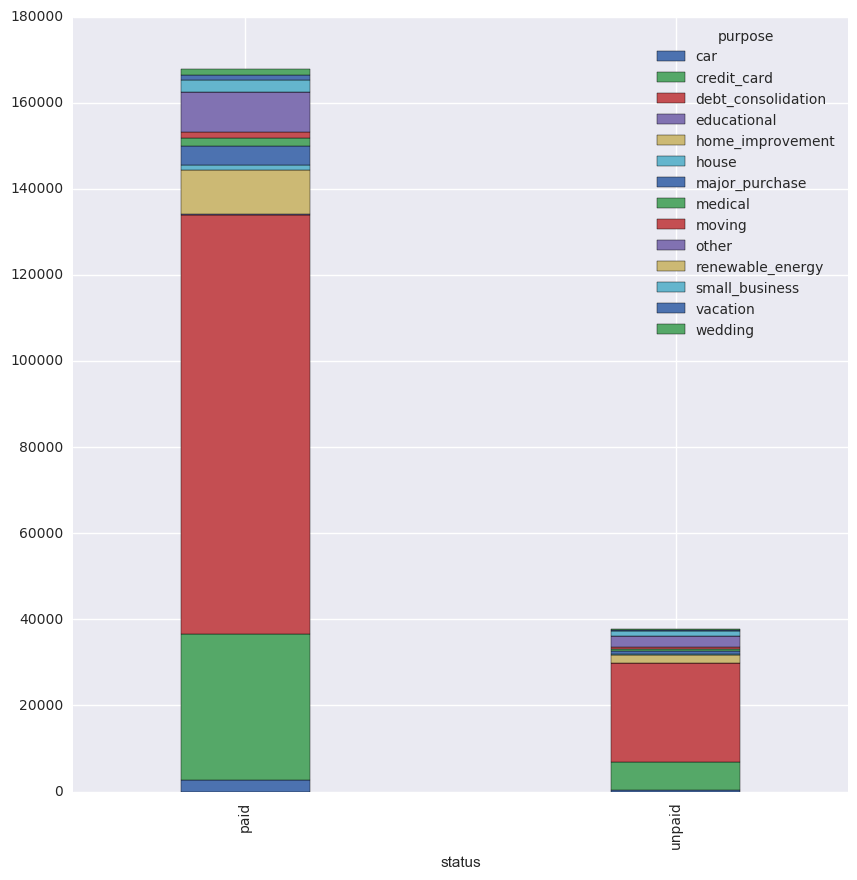

In [93]:
fig, axes = plt.subplots(1,1,figsize=(10,10))
temp.plot(ax = axes, kind = 'bar', stacked = True, width = 0.3)